In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys, warnings, os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# Track data loading
import psutil
import time

# Save & Load results
import pickle

In [2]:
import networkx as nx

import pandas as pd
import seaborn as sns

import datetime
from scipy import optimize

from itertools import product

# 1. Load data

In [5]:
st = time.time()

with open("data/graphs/G_filtered.gpickle", 'rb') as f:
    G_filtered = pickle.load(f)

et = time.time()
elapsed_time = et - st

print('Execution time:', elapsed_time/60, 'mins')
# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

Execution time: 1.544639257589976 mins
RAM memory % used: 80.3
RAM Used (GB): 321.2199936


In [6]:
def print_graph_info(G):
    print("Graph Type: ", type(G))
    print("Node Num: ", G.number_of_nodes())
    print("Edge Num: ", G.number_of_edges())
    print("Weight Sum: ", G.size(weight="weight"))

In [7]:
print_graph_info(G_filtered)

Graph Type:  <class 'networkx.classes.digraph.DiGraph'>
Node Num:  767553
Edge Num:  2165564
Weight Sum:  29991328.0


# 2. Variable preparations

## 2.1. Nodes Aligning (Static)

In [11]:
def get_keys_with_value(d, target_value):
    return list(filter(lambda k: d[k] == target_value, d))

In [12]:
nodes_aligning = nx.get_node_attributes(G_filtered, "extreme_aligning")

In [13]:
scientificNodes_aligned = get_keys_with_value(nodes_aligning, "scientific")
fakeNodes_aligned = get_keys_with_value(nodes_aligning, "fake")
uncertainNodes_aligned = get_keys_with_value(nodes_aligning, "uncertain")

In [14]:
alignedNodes = [scientificNodes_aligned, fakeNodes_aligned, uncertainNodes_aligned]
swayableNodes = get_keys_with_value(nodes_aligning, "NA")

## 2.2. TimeStamps

In [15]:
def cal_timestamps(date):
    
    start_timestamp = 1584482894
    
    # Define the start and end dates
    start_date = datetime.datetime.strptime('2020-03-17', '%Y-%m-%d')
    end_date = datetime.datetime.strptime(date, '%Y-%m-%d')

    # Calculate the difference in days
    difference_in_days = (end_date - start_date).days
    
    return start_timestamp + difference_in_days*24*60*60

In [16]:
def get_timeStamps_list(start_date_str, end_date_str):
    timeStamps_str_list = []
    
    # Convert the string dates to datetime.date objects
    start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d").date()
    end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d").date()

    # Current date starting from start_date
    current_date = start_date

    # Loop until the current date exceeds end_date
    counter = 0
    while current_date < end_date:
        
        if counter % 2 != 0:
            # Move to the 2th of the next month
            if current_date.month == 12:
                current_date = datetime.date(current_date.year + 1, 1, 2)
            else:
                current_date = datetime.date(current_date.year, current_date.month + 1, 2)
        else:
            # Move to the 17th of the same month
            current_date = datetime.date(current_date.year, current_date.month, 17)
            
        timeStamps_str_list.append(current_date.strftime("%Y-%m-%d"))
        
        counter += 1
            
    return timeStamps_str_list 

In [17]:
timeStamp1_list = get_timeStamps_list("2020-03-17", "2022-12-17")
timeStamp2_list = get_timeStamps_list("2020-04-17", "2023-01-17")
timeStamp3_list = get_timeStamps_list("2020-05-17", "2023-02-17")

## 2.3. Network construction (timeStamp1 - timeStamp2)

- Subgraph

In [15]:
def get_temporal_subgraph(G, timeStamp1, timeStamp2):
    
    subG = nx.DiGraph()
    
    node_timeStamps_dict = nx.get_node_attributes(G, "timeStamps")
    edge_timeStamps_dict = nx.get_edge_attributes(G, "timeStamps")
    
    for k,v in node_timeStamps_dict.items():
        index_mask = np.logical_and(v >= timeStamp1, v <= timeStamp2)
        if np.sum(index_mask) > 0:
            subG.add_node(k, timeStamps = G.nodes[k]['timeStamps'][index_mask], 
                             followers = G.nodes[k]['followers'][index_mask],
                             #friends = G.nodes[k]['friends'][index_mask],
                             #bot = G.nodes[k]['bot'][index_mask],
                             #verified = G.nodes[k]['verified'][index_mask],
                             extreme_aligning = G.nodes[k]['extreme_aligning'])
            
    for k,v in edge_timeStamps_dict.items():
        index_mask = np.logical_and(v >= timeStamp1, v <= timeStamp2)
        if np.sum(index_mask) > 0:
            subG.add_edge(k[0], k[1], weight = np.sum(index_mask),
                                      timeStamps = G.edges[k]['timeStamps'][index_mask], 
                                      newsCategories = G.edges[k]['newsCategories'][index_mask],
                                      newsCategoriesGeneralised = G.edges[k]['newsCategoriesGeneralised'][index_mask])
    
    # remove users whose follower count available, but doesn't retweet in the filtered network during specified period
    isolated_nodes = list(nx.isolates(subG))
    subG.remove_nodes_from(isolated_nodes)
    
    return subG

In [16]:
def get_subgraph_ofCategorisedRetweets(G, edge_stance, verbose = False):
    
    subG = nx.DiGraph()
    
    newsCategoriesGeneralised_dict = nx.get_edge_attributes(G, 'newsCategoriesGeneralised')
    
    for edge in list(G.edges):
        bool_arr = (newsCategoriesGeneralised_dict[edge] == edge_stance)
        if np.sum(bool_arr) > 0:
            subG.add_edge(edge[0], edge[1], weight = np.sum(bool_arr))
            
    if verbose:
        print_graph_info(subG)
    
    return subG

- Follower count

In [17]:
def get_subgraph_followerCount_begin(G, nodes):
    
    followerCount_begin_dict = {}

    for node in nodes:
        followerCount_begin_dict.update({node: G.nodes[node]["followers"][0]})
    
    return followerCount_begin_dict

In [18]:
def get_subgraph_followerCount_end(G, nodes):
    
    followerCount_end_dict = {}

    for node in nodes:
        followerCount_end_dict.update({node: G.nodes[node]["followers"][-1]})
    
    return followerCount_end_dict

## 2.4. Predicting follower count variations (timeStamp2 - timeStamp3)

In [19]:
def get_window_followerCountIncrease(nodes, timeStamp2, timeStamp3):
    
    followerCountSum_start = 0
    followerCountSum_end = 0
    
    for node in nodes:
        bool_arr1 = (np.array(G_filtered.nodes[node]['timeStamps']) >= timeStamp2)
        bool_arr2 = (np.array(G_filtered.nodes[node]['timeStamps']) <= timeStamp3)
        bool_arr = np.logical_and(bool_arr1, bool_arr2)
        if np.sum(bool_arr) > 1: 
            start = np.array(G_filtered.nodes[node]["followers"])[bool_arr][0]
            end = np.array(G_filtered.nodes[node]["followers"])[bool_arr][-1]
            
            followerCountSum_start += start
            followerCountSum_end += end
    
    return followerCountSum_end/followerCountSum_start - 1

In [20]:
def cal_true_increaseRate(timeStamp2_list, timeStamp3_list, stance):
    
    st = time.time()
    true_increaseRate_arr = np.zeros(len(timeStamp2_list))
    
    print('Counter:', end = ' ')
    for i in range(len(timeStamp2_list)):
        print(i, end = ' ')
        timeStamp2_convert = cal_timestamps(timeStamp2_list[i]); timeStamp3_convert = cal_timestamps(timeStamp3_list[i])
        true_increaseRate_arr[i] = get_window_followerCountIncrease(alignedNodes[stance], timeStamp2_convert, timeStamp3_convert)
    
    save_address = "results/epiSim/epiProp_1Month/trueIncreaseRateArr" + "_stance_" + str(stance) + ".pkl"
    with open(save_address, "wb") as file:
        pickle.dump(true_increaseRate_arr, file)
    
    et = time.time(); elapsed_time = et - st
    print('Complete. Execution time:', elapsed_time/60, 'mins')

In [67]:
cal_true_increaseRate(timeStamp2_list, timeStamp3_list, stance = 0)

Counter: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 Complete. Execution time: 0.9888126651446024 mins


In [68]:
cal_true_increaseRate(timeStamp2_list, timeStamp3_list, stance = 1)

Counter: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 Complete. Execution time: 0.2484147588411967 mins


In [69]:
cal_true_increaseRate(timeStamp2_list, timeStamp3_list, stance = 2)

Counter: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 Complete. Execution time: 2.71206754843394 mins


# 3. Simulation

In [21]:
def intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

In [22]:
def get_keys_with_value(d, target_value):
    return list(filter(lambda k: d[k] == target_value, d))

In [23]:
def get_keys_without_value(d, target_value):
    return list(filter(lambda k: d[k] != target_value, d))

In [24]:
def get_value_with_keys(d, target_keys):
    return list(map(d.get, target_keys))

In [25]:
# epi ode - for Newton-Raphson optimization
f = lambda x, S_initial, R0: 1 - x - S_initial * np.exp(-R0*x)
fprime = lambda x, S_initial, R0: -1 + S_initial * R0 * np.exp(-R0*x)

In [207]:
def get_window_creators_and_listeners(window_stance_subG, window_aligned_nodes, window_swayable_nodes):
    
    creators_aligned_nodes = [] # aligned nodes that can reach swayable users
    listeners_swayable_nodes = [] # swayable nodes that can be reached by aligned nodes
    
    for aligned_node in window_aligned_nodes:
        reachable_nodes = list(nx.dfs_tree(window_stance_subG, aligned_node).nodes())
        if len(reachable_nodes) > 0:
            creators_aligned_nodes.append(aligned_node)
            listeners_swayable_nodes += reachable_nodes
    
    listeners_swayable_nodes = intersection(listeners_swayable_nodes, window_swayable_nodes)
        
    return creators_aligned_nodes, listeners_swayable_nodes

In [208]:
def SIR_ode(timeStamp1, timeStamp2, stance, R0_arr, num_runs):
    
    st = time.time()
    
    # construct networks
    timeStamp1_convert = cal_timestamps(timeStamp1); timeStamp2_convert = cal_timestamps(timeStamp2)
    
    window_subG = get_temporal_subgraph(G_filtered, timeStamp1_convert, timeStamp2_convert)
    window_stance_subG = get_subgraph_ofCategorisedRetweets(window_subG, edge_stance = stance, verbose = False)
    
    window_aligned_nodes = intersection(list(window_stance_subG.nodes), alignedNodes[stance])
    window_swayable_nodes = intersection(list(window_stance_subG.nodes), swayableNodes)
    
    et = time.time(); elapsed_time = et - st
    print('Network extraction complete. Execution time:', elapsed_time/60, 'mins')
    
    # creators and listeners
    creators_aligned_nodes, listeners_swayable_nodes = get_window_creators_and_listeners(window_stance_subG, window_aligned_nodes, window_swayable_nodes)
    
    et = time.time(); elapsed_time = et - st
    print('Creators and listeners extraction complete. Execution time:', elapsed_time/60, 'mins')
    
    # epi ode
    S_initial = len(listeners_swayable_nodes)/len(creators_aligned_nodes + listeners_swayable_nodes); 
    x0 = [0.5]*len(R0_arr) # initial guess (any value between 0 and 1, since the root is unique)
    R_end_arr = optimize.newton(f, x0, fprime=fprime, args=(S_initial, R0_arr), maxiter = 100) # epidemic size
    listeners_recoveredNum_arr = np.rint((R_end_arr - (1 - S_initial)) * len(creators_aligned_nodes + listeners_swayable_nodes)).astype(int)

    et = time.time(); elapsed_time = et - st
    print('Epi sim complete. Execution time:', elapsed_time/60, 'mins')
    
    # followers count (timeStamp2)
    results = {}
    creators_aligned_followerCountSum = np.sum(list(get_subgraph_followerCount_end(window_subG, creators_aligned_nodes).values()))
    
    results = {}
    for i in range(len(R0_arr)):
        for j in range(num_runs):
            listeners_recovered_nodes = np.random.choice(listeners_swayable_nodes, int(listeners_recoveredNum_arr[i]), replace = False)
            listeners_recovered_followerCountSum = np.sum(list(get_subgraph_followerCount_end(window_subG, listeners_recovered_nodes).values()))
            results.update({(R0_arr[i], j): listeners_recovered_followerCountSum/creators_aligned_followerCountSum})
    
    et = time.time(); elapsed_time = et - st
    print('Prop computation complete. Execution time:', elapsed_time/60, 'mins')
    
    save_address = "results/epiSim/epiProp_1Month/timeStamp1_" + timeStamp1 + "_timeStamp2_" + timeStamp2 + "_stance_" + str(stance) + ".pkl" 
    with open(save_address, "wb") as file:
        pickle.dump(results, file)
        
    return results

In [209]:
R0_arr = np.round(np.arange(0.05, 5.05, 0.05), 2)
num_runs = 100

In [210]:
np.random.seed(1)

for i in range(len(timeStamp1_list)):
    timeStamp1 = timeStamp1_list[i]; timeStamp2 = timeStamp2_list[i]
    for stance in range(3):
        print("timeStamp1: " + timeStamp1 + " timeStamp2: " + timeStamp2 + " stance: "  + str(stance))
        SIR_ode(timeStamp1, timeStamp2, stance, R0_arr, num_runs)
        print("========================================")
        print()

timeStamp1: 2020-03-17 timeStamp2: 2020-04-17 stance: 0
Network extraction complete. Execution time: 0.8623441100120545 mins
Creators and listeners extraction complete. Execution time: 0.8750301202138265 mins
Epi sim complete. Execution time: 0.8750440120697022 mins
Prop computation complete. Execution time: 1.1546568234761556 mins

timeStamp1: 2020-03-17 timeStamp2: 2020-04-17 stance: 1
Network extraction complete. Execution time: 0.8511835773785908 mins
Creators and listeners extraction complete. Execution time: 0.8517333070437113 mins
Epi sim complete. Execution time: 0.8517422795295715 mins
Prop computation complete. Execution time: 0.8788295269012452 mins

timeStamp1: 2020-03-17 timeStamp2: 2020-04-17 stance: 2
Network extraction complete. Execution time: 0.9211177706718445 mins
Creators and listeners extraction complete. Execution time: 0.93805011510849 mins
Epi sim complete. Execution time: 0.9380838990211486 mins
Prop computation complete. Execution time: 1.361451808611552 mins

Network extraction complete. Execution time: 0.9012157281239828 mins
Creators and listeners extraction complete. Execution time: 0.9017311731974283 mins
Epi sim complete. Execution time: 0.9017390688260396 mins
Prop computation complete. Execution time: 0.9251940846443176 mins

timeStamp1: 2020-07-02 timeStamp2: 2020-08-02 stance: 2
Network extraction complete. Execution time: 0.9543364922205607 mins
Creators and listeners extraction complete. Execution time: 0.9715945521990458 mins
Epi sim complete. Execution time: 0.9716245651245117 mins
Prop computation complete. Execution time: 1.433554216225942 mins

timeStamp1: 2020-07-17 timeStamp2: 2020-08-17 stance: 0
Network extraction complete. Execution time: 0.9492817401885987 mins
Creators and listeners extraction complete. Execution time: 0.9641171773274739 mins
Epi sim complete. Execution time: 0.9641331672668457 mins
Prop computation complete. Execution time: 1.265986410776774 mins

timeStamp1: 2020-07-17 timeStamp2: 2020-08-17 stance:

Network extraction complete. Execution time: 0.8894738753636678 mins
Creators and listeners extraction complete. Execution time: 0.9056822856267294 mins
Epi sim complete. Execution time: 0.9057127873102824 mins
Prop computation complete. Execution time: 1.2934123873710632 mins

timeStamp1: 2020-11-02 timeStamp2: 2020-12-02 stance: 0
Network extraction complete. Execution time: 0.8516814072926839 mins
Creators and listeners extraction complete. Execution time: 0.8590529839197795 mins
Epi sim complete. Execution time: 0.859066883722941 mins
Prop computation complete. Execution time: 1.0727413455645243 mins

timeStamp1: 2020-11-02 timeStamp2: 2020-12-02 stance: 1
Network extraction complete. Execution time: 0.7830148379007975 mins
Creators and listeners extraction complete. Execution time: 0.7836757063865661 mins
Epi sim complete. Execution time: 0.7836846868197124 mins
Prop computation complete. Execution time: 0.7979032715161641 mins

timeStamp1: 2020-11-02 timeStamp2: 2020-12-02 stance

Network extraction complete. Execution time: 0.7879163702329 mins
Creators and listeners extraction complete. Execution time: 0.7933050394058228 mins
Epi sim complete. Execution time: 0.7933165828386942 mins
Prop computation complete. Execution time: 0.9897295713424683 mins

timeStamp1: 2021-02-17 timeStamp2: 2021-03-17 stance: 1
Network extraction complete. Execution time: 0.7346238017082214 mins
Creators and listeners extraction complete. Execution time: 0.7351044257481892 mins
Epi sim complete. Execution time: 0.7351127584775289 mins
Prop computation complete. Execution time: 0.7493284463882446 mins

timeStamp1: 2021-02-17 timeStamp2: 2021-03-17 stance: 2
Network extraction complete. Execution time: 0.8122503439585368 mins
Creators and listeners extraction complete. Execution time: 0.8227164149284363 mins
Epi sim complete. Execution time: 0.822740372021993 mins
Prop computation complete. Execution time: 1.1293898701667786 mins

timeStamp1: 2021-03-02 timeStamp2: 2021-04-02 stance: 0

Network extraction complete. Execution time: 0.7075096925099691 mins
Creators and listeners extraction complete. Execution time: 0.7081229050954183 mins
Epi sim complete. Execution time: 0.7081318656603496 mins
Prop computation complete. Execution time: 0.7207388957341512 mins

timeStamp1: 2021-06-02 timeStamp2: 2021-07-02 stance: 2
Network extraction complete. Execution time: 0.7737347046534221 mins
Creators and listeners extraction complete. Execution time: 0.7858008305231731 mins
Epi sim complete. Execution time: 0.7858178814252218 mins
Prop computation complete. Execution time: 1.0139989535013834 mins

timeStamp1: 2021-06-17 timeStamp2: 2021-07-17 stance: 0
Network extraction complete. Execution time: 0.7631831725438436 mins
Creators and listeners extraction complete. Execution time: 0.7723404924074809 mins
Epi sim complete. Execution time: 0.7723546783129375 mins
Prop computation complete. Execution time: 0.9541190544764201 mins

timeStamp1: 2021-06-17 timeStamp2: 2021-07-17 stanc

Network extraction complete. Execution time: 0.7730775515238444 mins
Creators and listeners extraction complete. Execution time: 0.7796032826105753 mins
Epi sim complete. Execution time: 0.7796220660209656 mins
Prop computation complete. Execution time: 1.0073389649391173 mins

timeStamp1: 2021-10-02 timeStamp2: 2021-11-02 stance: 0
Network extraction complete. Execution time: 0.7193940321604411 mins
Creators and listeners extraction complete. Execution time: 0.7224291364351908 mins
Epi sim complete. Execution time: 0.7224397381146749 mins
Prop computation complete. Execution time: 0.8482858379681905 mins

timeStamp1: 2021-10-02 timeStamp2: 2021-11-02 stance: 1
Network extraction complete. Execution time: 0.7481611371040344 mins
Creators and listeners extraction complete. Execution time: 0.7489611307779948 mins
Epi sim complete. Execution time: 0.7489689946174621 mins
Prop computation complete. Execution time: 0.7656078100204468 mins

timeStamp1: 2021-10-02 timeStamp2: 2021-11-02 stanc

Network extraction complete. Execution time: 0.6906540552775066 mins
Creators and listeners extraction complete. Execution time: 0.6959978063901265 mins
Epi sim complete. Execution time: 0.6960129539171854 mins
Prop computation complete. Execution time: 0.879991102218628 mins

timeStamp1: 2022-02-02 timeStamp2: 2022-03-02 stance: 0
Network extraction complete. Execution time: 0.6813678542772929 mins
Creators and listeners extraction complete. Execution time: 0.6827456792195638 mins
Epi sim complete. Execution time: 0.6827544093132019 mins
Prop computation complete. Execution time: 0.7560530702273051 mins

timeStamp1: 2022-02-02 timeStamp2: 2022-03-02 stance: 1
Network extraction complete. Execution time: 0.6333292841911315 mins
Creators and listeners extraction complete. Execution time: 0.6346742590268453 mins
Epi sim complete. Execution time: 0.6346831679344177 mins
Prop computation complete. Execution time: 0.6466764609018961 mins

timeStamp1: 2022-02-02 timeStamp2: 2022-03-02 stance

Network extraction complete. Execution time: 0.5845236261685689 mins
Creators and listeners extraction complete. Execution time: 0.5852941393852233 mins
Epi sim complete. Execution time: 0.5853030880292257 mins
Prop computation complete. Execution time: 0.639110000928243 mins

timeStamp1: 2022-05-17 timeStamp2: 2022-06-17 stance: 1
Network extraction complete. Execution time: 0.6153317093849182 mins
Creators and listeners extraction complete. Execution time: 0.6156034668286642 mins
Epi sim complete. Execution time: 0.6156099081039429 mins
Prop computation complete. Execution time: 0.6224266131718953 mins

timeStamp1: 2022-05-17 timeStamp2: 2022-06-17 stance: 2
Network extraction complete. Execution time: 0.5869623819986979 mins
Creators and listeners extraction complete. Execution time: 0.5888534148534139 mins
Epi sim complete. Execution time: 0.5888646205266317 mins
Prop computation complete. Execution time: 0.654067858060201 mins

timeStamp1: 2022-06-02 timeStamp2: 2022-07-02 stance:

Network extraction complete. Execution time: 0.5654204487800598 mins
Creators and listeners extraction complete. Execution time: 0.5655932903289795 mins
Epi sim complete. Execution time: 0.5656016707420349 mins
Prop computation complete. Execution time: 0.5728617946306864 mins

timeStamp1: 2022-09-02 timeStamp2: 2022-10-02 stance: 2
Network extraction complete. Execution time: 0.5716447234153748 mins
Creators and listeners extraction complete. Execution time: 0.5729901234308878 mins
Epi sim complete. Execution time: 0.5729983290036519 mins
Prop computation complete. Execution time: 0.625271753470103 mins

timeStamp1: 2022-09-17 timeStamp2: 2022-10-17 stance: 0
Network extraction complete. Execution time: 0.6050564567248027 mins
Creators and listeners extraction complete. Execution time: 0.6055399815241496 mins
Epi sim complete. Execution time: 0.605547567208608 mins
Prop computation complete. Execution time: 0.641737453142802 mins

timeStamp1: 2022-09-17 timeStamp2: 2022-10-17 stance: 

Network extraction complete. Execution time: 0.5761693120002747 mins
Creators and listeners extraction complete. Execution time: 0.5774310946464538 mins
Epi sim complete. Execution time: 0.5774407068888346 mins
Prop computation complete. Execution time: 0.6219287713368734 mins



# 4. Optimisation

- Load results

In [18]:
def load_results(timeStamp1_list, timeStamp2_list, timeStamp3_list, R0_arr, num_runs):
    
    st = time.time()
    
    # simulation results
    keys_list = [(R0, run) for R0 in R0_arr for run in range(num_runs)]
    prop_arr = []

    for i in range(len(timeStamp1_list)):
        timeStamp1 = timeStamp1_list[i]; timeStamp2 = timeStamp2_list[i]
        temp = []
        for stance in range(3):
            save_address = "results/epiSim/epiProp_1Month/timeStamp1_" + timeStamp1 + "_timeStamp2_" + timeStamp2 + "_stance_" + str(stance) + ".pkl"
            with open(save_address, "rb") as file:               
                load_dict = pickle.load(file)
            temp.append(np.array(list(load_dict.values())))
        prop_arr.append(temp)
    prop_dict = dict(zip(keys_list, np.array(prop_arr).T)) 
    
    # true increase rate
    true_increaseRate_arr = []
    for i in range(3):
        save_address = "results/epiSim/epiProp_1Month/trueIncreaseRateArr" + "_stance_" + str(i) + ".pkl"
        with open(save_address, "rb") as file:
            true_increaseRate_arr.append(pickle.load(file))
    true_increaseRate_arr = np.array(true_increaseRate_arr)
    
    et = time.time(); elapsed_time = et - st
    print('Load results complete. Execution time:', elapsed_time/60, 'mins')
    
    return prop_dict, true_increaseRate_arr

In [19]:
R0_arr = np.round(np.arange(0.05, 5.05, 0.05), 2)
num_runs = 100

In [20]:
prop_dict, true_increaseRate_arr = load_results(timeStamp1_list, timeStamp2_list, timeStamp3_list, R0_arr, num_runs)

Load results complete. Execution time: 0.029722487926483153 mins


- 10%

In [21]:
def cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent):
    
    keys = list(zip(R0_arr, len(R0_arr) * [5]))
    squared_error_dict = {k: np.sum((prop_dict[k] * delta - true_increaseRate_arr)**2, axis = 0) for k in keys}
    
    # Compute the threshold for the smallest percent% errors at each timestamp
    squared_error_keys = list(squared_error_dict.keys())
    squared_error_values = np.array(list(squared_error_dict.values()))
    threshold = np.percentile(squared_error_values, percent, axis = 0)
    mask_arr = squared_error_values < threshold
    
    filtered_R0_seed_list = []
    filtered_squared_error_list = []
    for timeStamp_index in range(np.shape(mask_arr)[1]):
        index_arr = np.arange(0, np.shape(mask_arr)[0], 1)
        filtered_R0_seed_list.append([squared_error_keys[i] for i in index_arr[mask_arr[:, timeStamp_index]]])
        filtered_squared_error_list.append(squared_error_values[:, timeStamp_index][mask_arr[:, timeStamp_index]])
    
    return filtered_R0_seed_list, filtered_squared_error_list

In [27]:
percent = 10
from scipy.optimize import minimize

def wrapper_function(delta):
    filtered_squared_error_list = cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent)[1]
    return np.sum(filtered_squared_error_list)/np.shape(filtered_squared_error_list)[0]

results = minimize(wrapper_function, x0 = [0.01], method = "Nelder-Mead")
print(results)

delta = results["x"][0]
filtered_R0_seed_list, filtered_squared_error_list = cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent)

 final_simplex: (array([[0.017    ],
       [0.0170625]]), array([0.00020234, 0.00020235]))
           fun: 0.00020234085351905035
       message: 'Optimization terminated successfully.'
          nfev: 21
           nit: 10
        status: 0
       success: True
             x: array([0.017])


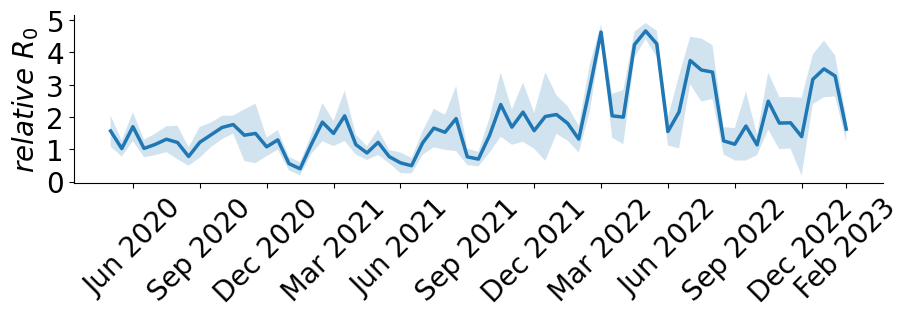

In [28]:
fig, axs = plt.subplots(figsize = (9, 3), constrained_layout = True)

filtered_R0_arr = np.array([np.array(filtered_R0_seed_list[i])[:, 0] for i in range(len(filtered_R0_seed_list))])
y = np.average(filtered_R0_arr, axis = 1)
std = np.std(filtered_R0_arr, axis = 1)
x = np.arange(0, len(y), 1)

plt.plot(x, y, linewidth = 2.5)
plt.fill_between(x, y - std, y + std, alpha = 0.2)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]) + 2) + [66]
x_tick = ["Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)
#plt.ylim(0, 5)
#plt.yscale('log')

plt.ylabel(r'$\it{relative}\ R_0$', fontsize=20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)

In [29]:
save_address = "results/epiSim/epiProp_1Month/filtered_R0_arr_10percent.pkl"
with open(save_address, "wb") as file:
    pickle.dump(filtered_R0_arr, file)

In [30]:
def cal_optimal_pred(delta, prop_dict, filtered_R0_seed_list):
    
    optimal_pred_arr = []
    optimal_std_arr = []
    
    for i in range(len(filtered_R0_seed_list)):
        
        R0_seed_list = filtered_R0_seed_list[i]
        
        optimal_pred_arr.append(np.average([prop_dict[k][:, i] * delta for k in R0_seed_list], axis = 0))
        optimal_std_arr.append(np.std([prop_dict[k][:, i] * delta for k in R0_seed_list], axis = 0))
    
    return np.array(optimal_pred_arr), np.array(optimal_std_arr)

In [31]:
optimal_pred_arr, optimal_std_arr = cal_optimal_pred(delta, prop_dict, filtered_R0_seed_list)

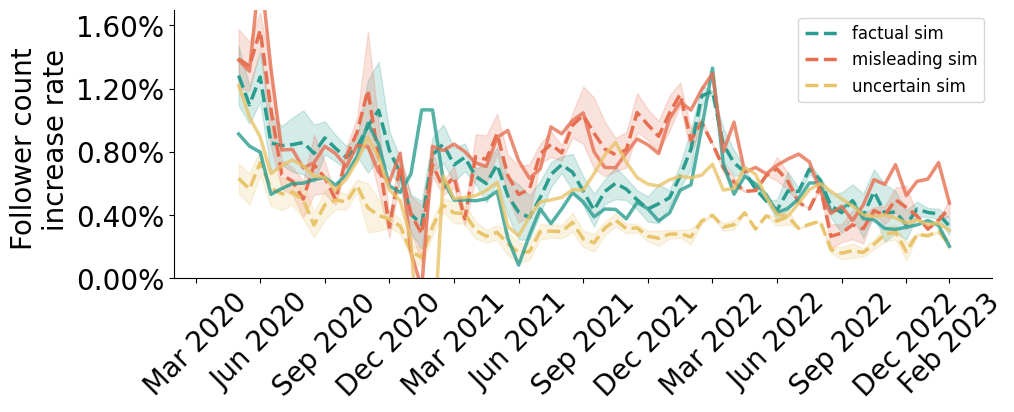

In [32]:
from matplotlib.ticker import MaxNLocator

from matplotlib.ticker import PercentFormatter

colour_palette = {"scientific":"#2a9d8f", "fake":"#e76f51", "uncertain":"#e9c46a"}

fig, axs = plt.subplots(figsize = (10, 4), constrained_layout = True)

x = np.arange(0, len(optimal_pred_arr[:, 0]), 1)

plt.plot(x, optimal_pred_arr[:, 0], linestyle = "dashed", color = colour_palette["scientific"], label = "factual sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 1], linestyle = "dashed", color = colour_palette["fake"], label = "misleading sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 2], linestyle = "dashed", color = colour_palette["uncertain"], label = "uncertain sim", linewidth = 2.5, alpha = 1)

plt.fill_between(x, optimal_pred_arr[:, 0] - optimal_std_arr[:, 0], optimal_pred_arr[:, 0] + optimal_std_arr[:, 0], alpha = 0.2, color = colour_palette["scientific"])
plt.fill_between(x, optimal_pred_arr[:, 1] - optimal_std_arr[:, 1], optimal_pred_arr[:, 1] + optimal_std_arr[:, 1], alpha = 0.2, color = colour_palette["fake"])
plt.fill_between(x, optimal_pred_arr[:, 2] - optimal_std_arr[:, 2], optimal_pred_arr[:, 2] + optimal_std_arr[:, 2], alpha = 0.2, color = colour_palette["uncertain"])

plt.plot(x, true_increaseRate_arr[0, :], color = colour_palette["scientific"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[1, :], color = colour_palette["fake"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[2, :], color = colour_palette["uncertain"], linewidth = 2.5, alpha = 0.8)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]) - 4) + [66]
x_tick = ["Mar 2020", "Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)

plt.ylabel('Follower count \n increase rate', fontsize = 20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(-6, len(optimal_pred_arr[:, 0]) + 3)
plt.ylim(0.000, 0.017)
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.legend(fontsize = 12)

fig.savefig('figures/fig4a.png', dpi=400, bbox_inches = 'tight')

- 5% (SM)

In [33]:
percent = 5
from scipy.optimize import minimize

results = minimize(wrapper_function, x0 = [0.01], method = "Nelder-Mead")
print(results)

delta = results["x"][0]
filtered_R0_seed_list, filtered_squared_error_list = cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent)

 final_simplex: (array([[0.0201875],
       [0.020125 ]]), array([8.60076991e-05, 8.60080755e-05]))
           fun: 8.60076991259643e-05
       message: 'Optimization terminated successfully.'
          nfev: 24
           nit: 12
        status: 0
       success: True
             x: array([0.0201875])


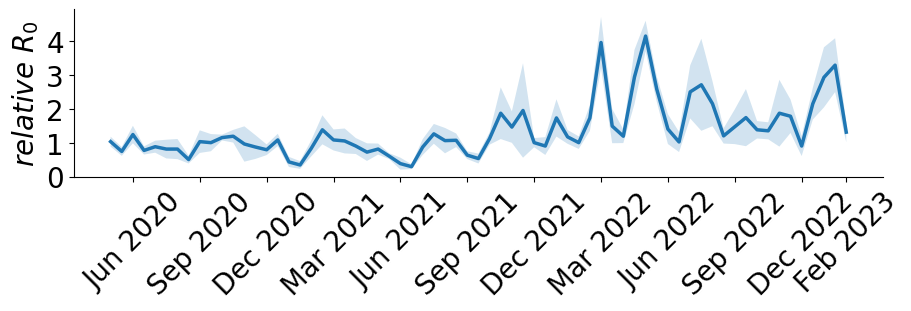

In [34]:
fig, axs = plt.subplots(figsize = (9, 3), constrained_layout = True)

filtered_R0_arr = np.array([np.array(filtered_R0_seed_list[i])[:, 0] for i in range(len(filtered_R0_seed_list))])
y = np.average(filtered_R0_arr, axis = 1)
std = np.std(filtered_R0_arr, axis = 1)
x = np.arange(0, len(y), 1)

plt.plot(x, y, linewidth = 2.5)
plt.fill_between(x, y - std, y + std, alpha = 0.2)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]) + 2) + [66]
x_tick = ["Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)
#plt.ylim(0, 5)
#plt.yscale('log')

plt.ylabel(r'$\it{relative}\ R_0$', fontsize=20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)

In [35]:
save_address = "Results/EpiSim/EpiProp_1Month/filtered_R0_arr_5percent.pkl"
with open(save_address, "wb") as file:
    pickle.dump(filtered_R0_arr, file)

In [36]:
optimal_pred_arr, optimal_std_arr = cal_optimal_pred(delta, prop_dict, filtered_R0_seed_list)

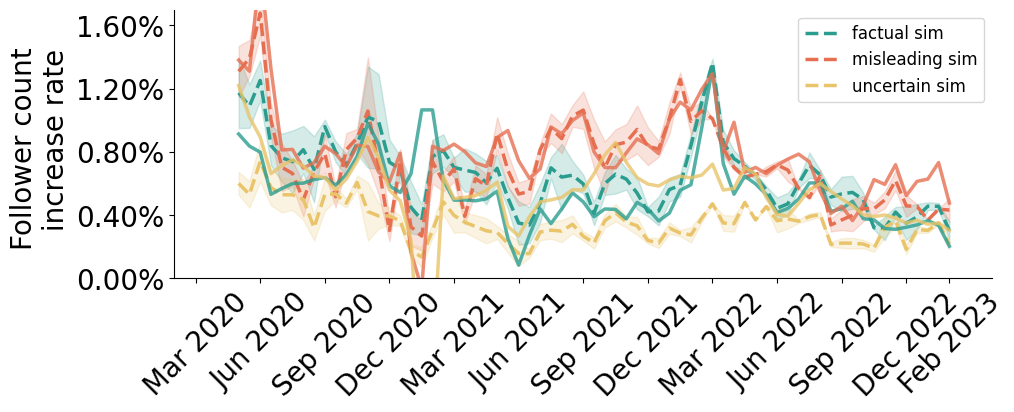

In [37]:
fig, axs = plt.subplots(figsize = (10, 4), constrained_layout = True)

x = np.arange(0, len(optimal_pred_arr[:, 0]), 1)

plt.plot(x, optimal_pred_arr[:, 0], linestyle = "dashed", color = colour_palette["scientific"], label = "factual sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 1], linestyle = "dashed", color = colour_palette["fake"], label = "misleading sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 2], linestyle = "dashed", color = colour_palette["uncertain"], label = "uncertain sim", linewidth = 2.5, alpha = 1)

plt.fill_between(x, optimal_pred_arr[:, 0] - optimal_std_arr[:, 0], optimal_pred_arr[:, 0] + optimal_std_arr[:, 0], alpha = 0.2, color = colour_palette["scientific"])
plt.fill_between(x, optimal_pred_arr[:, 1] - optimal_std_arr[:, 1], optimal_pred_arr[:, 1] + optimal_std_arr[:, 1], alpha = 0.2, color = colour_palette["fake"])
plt.fill_between(x, optimal_pred_arr[:, 2] - optimal_std_arr[:, 2], optimal_pred_arr[:, 2] + optimal_std_arr[:, 2], alpha = 0.2, color = colour_palette["uncertain"])

plt.plot(x, true_increaseRate_arr[0, :], color = colour_palette["scientific"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[1, :], color = colour_palette["fake"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[2, :], color = colour_palette["uncertain"], linewidth = 2.5, alpha = 0.8)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]) - 4) + [66]
x_tick = ["Mar 2020", "Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)

plt.ylabel('Follower count \n increase rate', fontsize = 20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(-6, len(optimal_pred_arr[:, 0]) + 3)
plt.ylim(0.000, 0.017)
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.legend(fontsize = 12)

fig.savefig('figures/SM_fig8a.png', dpi=400, bbox_inches = 'tight')

- 20% (SM)

In [38]:
percent = 20
from scipy.optimize import minimize

results = minimize(wrapper_function, x0 = [0.01], method = "Nelder-Mead")
print(results)

delta = results["x"][0]
filtered_R0_seed_list, filtered_squared_error_list = cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent)

 final_simplex: (array([[0.0143125],
       [0.014375 ]]), array([0.00052181, 0.00052182]))
           fun: 0.0005218138770798301
       message: 'Optimization terminated successfully.'
          nfev: 16
           nit: 8
        status: 0
       success: True
             x: array([0.0143125])


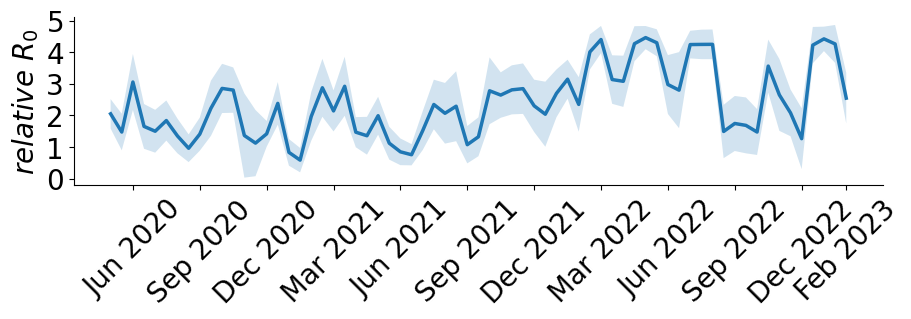

In [39]:
fig, axs = plt.subplots(figsize = (9, 3), constrained_layout = True)

filtered_R0_arr = np.array([np.array(filtered_R0_seed_list[i])[:, 0] for i in range(len(filtered_R0_seed_list))])
y = np.average(filtered_R0_arr, axis = 1)
std = np.std(filtered_R0_arr, axis = 1)
x = np.arange(0, len(y), 1)

plt.plot(x, y, linewidth = 2.5)
plt.fill_between(x, y - std, y + std, alpha = 0.2)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]) + 2) + [66]
x_tick = ["Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)
#plt.ylim(0, 5)
#plt.yscale('log')

plt.ylabel(r'$\it{relative}\ R_0$', fontsize=20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)

In [40]:
save_address = "Results/EpiSim/EpiProp_1Month/filtered_R0_arr_20percent.pkl"
with open(save_address, "wb") as file:
    pickle.dump(filtered_R0_arr, file)

In [41]:
optimal_pred_arr, optimal_std_arr = cal_optimal_pred(delta, prop_dict, filtered_R0_seed_list)

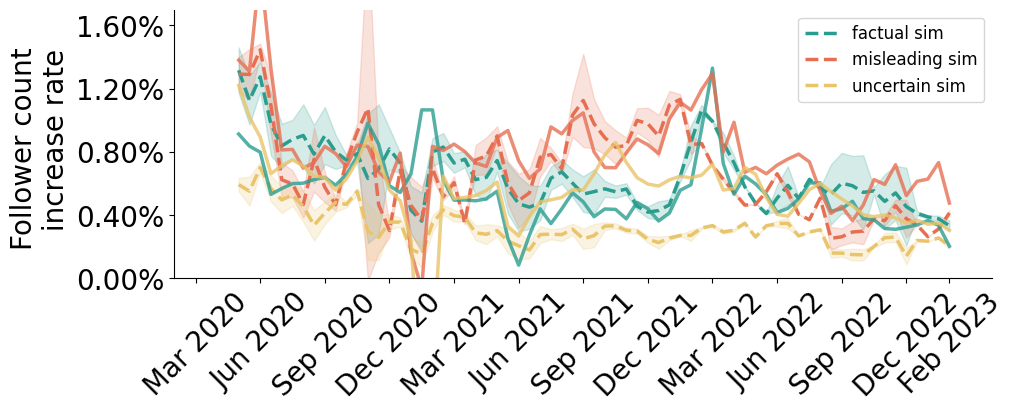

In [42]:
fig, axs = plt.subplots(figsize = (10, 4), constrained_layout = True)

x = np.arange(0, len(optimal_pred_arr[:, 0]), 1)

plt.plot(x, optimal_pred_arr[:, 0], linestyle = "dashed", color = colour_palette["scientific"], label = "factual sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 1], linestyle = "dashed", color = colour_palette["fake"], label = "misleading sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 2], linestyle = "dashed", color = colour_palette["uncertain"], label = "uncertain sim", linewidth = 2.5, alpha = 1)

plt.fill_between(x, optimal_pred_arr[:, 0] - optimal_std_arr[:, 0], optimal_pred_arr[:, 0] + optimal_std_arr[:, 0], alpha = 0.2, color = colour_palette["scientific"])
plt.fill_between(x, optimal_pred_arr[:, 1] - optimal_std_arr[:, 1], optimal_pred_arr[:, 1] + optimal_std_arr[:, 1], alpha = 0.2, color = colour_palette["fake"])
plt.fill_between(x, optimal_pred_arr[:, 2] - optimal_std_arr[:, 2], optimal_pred_arr[:, 2] + optimal_std_arr[:, 2], alpha = 0.2, color = colour_palette["uncertain"])

plt.plot(x, true_increaseRate_arr[0, :], color = colour_palette["scientific"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[1, :], color = colour_palette["fake"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[2, :], color = colour_palette["uncertain"], linewidth = 2.5, alpha = 0.8)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]) - 4) + [66]
x_tick = ["Mar 2020", "Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)

plt.ylabel('Follower count \n increase rate', fontsize = 20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(-6, len(optimal_pred_arr[:, 0]) + 3)
plt.ylim(0.000, 0.017)
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.legend(fontsize = 12)

fig.savefig('figures/SM_fig9a.png', dpi=400, bbox_inches = 'tight')

- 50% (SM)

In [43]:
percent = 50
from scipy.optimize import minimize

results = minimize(wrapper_function, x0 = [0.01], method = "Nelder-Mead")
print(results)

delta = results["x"][0]
filtered_R0_seed_list, filtered_squared_error_list = cal_squared_error(delta, prop_dict, true_increaseRate_arr, percent)

 final_simplex: (array([[0.009    ],
       [0.0090625]]), array([0.0025983, 0.0025985]))
           fun: 0.0025983019870365496
       message: 'Optimization terminated successfully.'
          nfev: 12
           nit: 6
        status: 0
       success: True
             x: array([0.009])


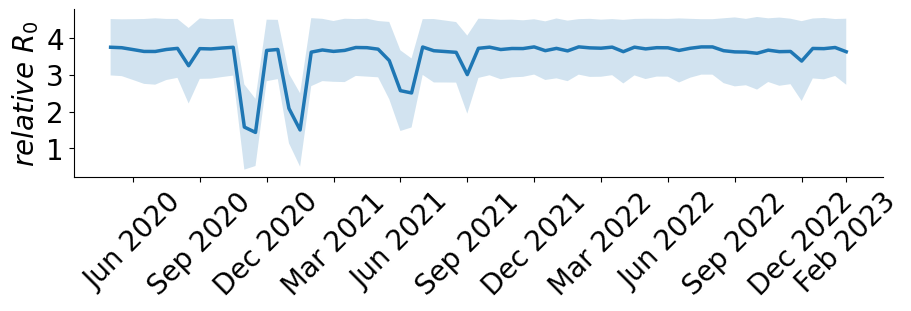

In [44]:
fig, axs = plt.subplots(figsize = (9, 3), constrained_layout = True)

filtered_R0_arr = np.array([np.array(filtered_R0_seed_list[i])[:, 0] for i in range(len(filtered_R0_seed_list))])
y = np.average(filtered_R0_arr, axis = 1)
std = np.std(filtered_R0_arr, axis = 1)
x = np.arange(0, len(y), 1)

plt.plot(x, y, linewidth = 2.5)
plt.fill_between(x, y - std, y + std, alpha = 0.2)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]) + 2) + [66]
x_tick = ["Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)
#plt.ylim(0, 5)
#plt.yscale('log')

plt.ylabel(r'$\it{relative}\ R_0$', fontsize=20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)

In [45]:
save_address = "Results/EpiSim/EpiProp_1Month/filtered_R0_arr_50percent.pkl"
with open(save_address, "wb") as file:
    pickle.dump(filtered_R0_arr, file)

In [46]:
optimal_pred_arr, optimal_std_arr = cal_optimal_pred(delta, prop_dict, filtered_R0_seed_list)

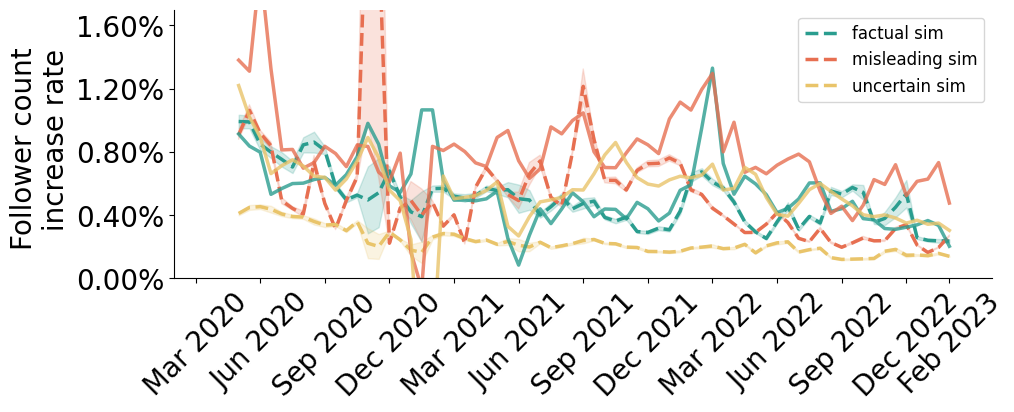

In [47]:
fig, axs = plt.subplots(figsize = (10, 4), constrained_layout = True)

x = np.arange(0, len(optimal_pred_arr[:, 0]), 1)

plt.plot(x, optimal_pred_arr[:, 0], linestyle = "dashed", color = colour_palette["scientific"], label = "factual sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 1], linestyle = "dashed", color = colour_palette["fake"], label = "misleading sim", linewidth = 2.5, alpha = 1)
plt.plot(x, optimal_pred_arr[:, 2], linestyle = "dashed", color = colour_palette["uncertain"], label = "uncertain sim", linewidth = 2.5, alpha = 1)

plt.fill_between(x, optimal_pred_arr[:, 0] - optimal_std_arr[:, 0], optimal_pred_arr[:, 0] + optimal_std_arr[:, 0], alpha = 0.2, color = colour_palette["scientific"])
plt.fill_between(x, optimal_pred_arr[:, 1] - optimal_std_arr[:, 1], optimal_pred_arr[:, 1] + optimal_std_arr[:, 1], alpha = 0.2, color = colour_palette["fake"])
plt.fill_between(x, optimal_pred_arr[:, 2] - optimal_std_arr[:, 2], optimal_pred_arr[:, 2] + optimal_std_arr[:, 2], alpha = 0.2, color = colour_palette["uncertain"])

plt.plot(x, true_increaseRate_arr[0, :], color = colour_palette["scientific"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[1, :], color = colour_palette["fake"], linewidth = 2.5, alpha = 0.8)
plt.plot(x, true_increaseRate_arr[2, :], color = colour_palette["uncertain"], linewidth = 2.5, alpha = 0.8)

index = list(np.array([(i)*6 for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]) - 4) + [66]
x_tick = ["Mar 2020", "Jun 2020", "Sep 2020", "Dec 2020", "Mar 2021", "Jun 2021", "Sep 2021", "Dec 2021", "Mar 2022", "Jun 2022", "Sep 2022", "Dec 2022", "Feb 2023"]
plt.xticks(index, x_tick, fontsize = 20, rotation = 45) 
plt.yticks(fontsize = 20)

plt.ylabel('Follower count \n increase rate', fontsize = 20)
axs.spines['right'].set_visible(False); axs.spines['top'].set_visible(False)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(-6, len(optimal_pred_arr[:, 0]) + 3)
plt.ylim(0.000, 0.017)
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))
plt.legend(fontsize = 12)

fig.savefig('figures/SM_fig10a.png', dpi=400, bbox_inches = 'tight')